In [4]:
from trees_emulator.load_data import *
from trees_emulator.predicting import *
import numpy as np
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
# Load Data
data = LoadData(2016, site="MHD", verbose=True)

Loading Meteorology data from data/met/EUROPE*10magl*2016*.nc
Loading footprint data from data/fps/MHD-10magl*2016*.nc
Cutting data to size
Loading extra meteorology from data/met/EUROPE*verticalgradients*2016*.nc and extracting gradients
Extracting wind vectors
All data loaded


In [6]:
# Load trained model. Info is a dict with general info about the training, clfs is a list of length size**2 with all regressors
with open('trained_models/MHD.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("info:", info)
print("first regressor:", clfs[0])

info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}
first regressor: GradientBoostingRegressor(loss='absolute_error', max_depth=50,
                          max_features='sqrt', n_estimators=150)


In [7]:
# Get the inputs set up
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data.y_wind, data.x_wind, data.met.PBLH.values]
hours_before = 6
## variables that are only passed at the time of the footprint
vars_without_past = [data.temp_grad, data.x_wind_grad, data.y_wind_grad]

inputs = get_all_inputs(vars_with_past, 6, vars_without_past)

In [8]:
# Load the fluxes. Here fluxes are EDGARv6 regridded using a 2D mass-conservative regridding function, acrg.grid.regrid.regrid2d (https://github.com/ACRG-Bristol/acrg/blob/develop/acrg/grid/regrid.py)
fluxes_og = xr.open_dataset("data/fluxes/ch4_EUROPE_2016_EDGARv6_regridded.nc")
fluxes = fluxes_og.sel(lat=data.fp_lats, lon= data.fp_lons, method="nearest")
fluxes = fluxes.flux.values

In [9]:
## make predictions using the trained model and the new data 
## predictions is a class that contains the real and emulated footprints under 
## predictions.truths and predictions.predictions, of shape (n_footprints, n_regressors each)
predictions = MakePredictions(clfs, data, inputs, hours_before)
true_flux, pred_flux = predictions.predict_fluxes(fluxes)

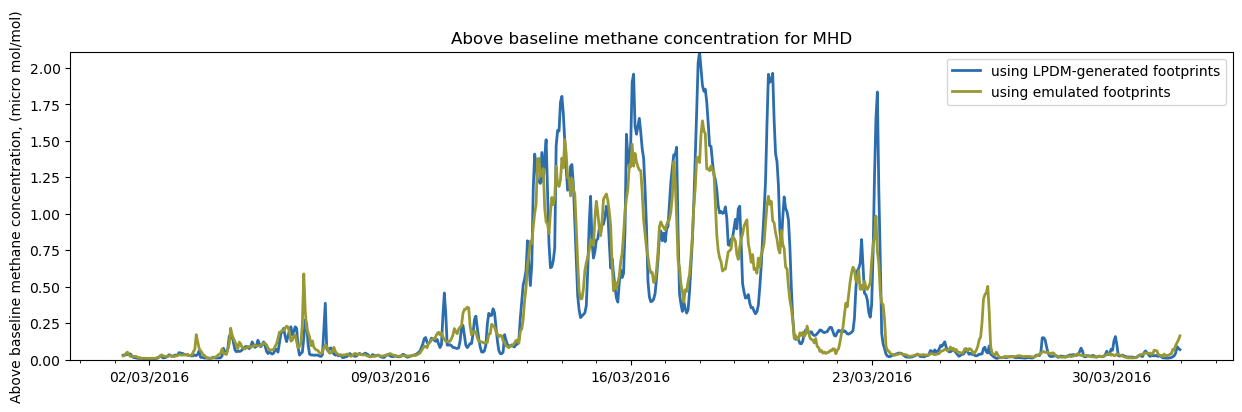

In [10]:
## plot above baseline mole fraction 
month = 3 # March
plot_flux(predictions, data, 3)

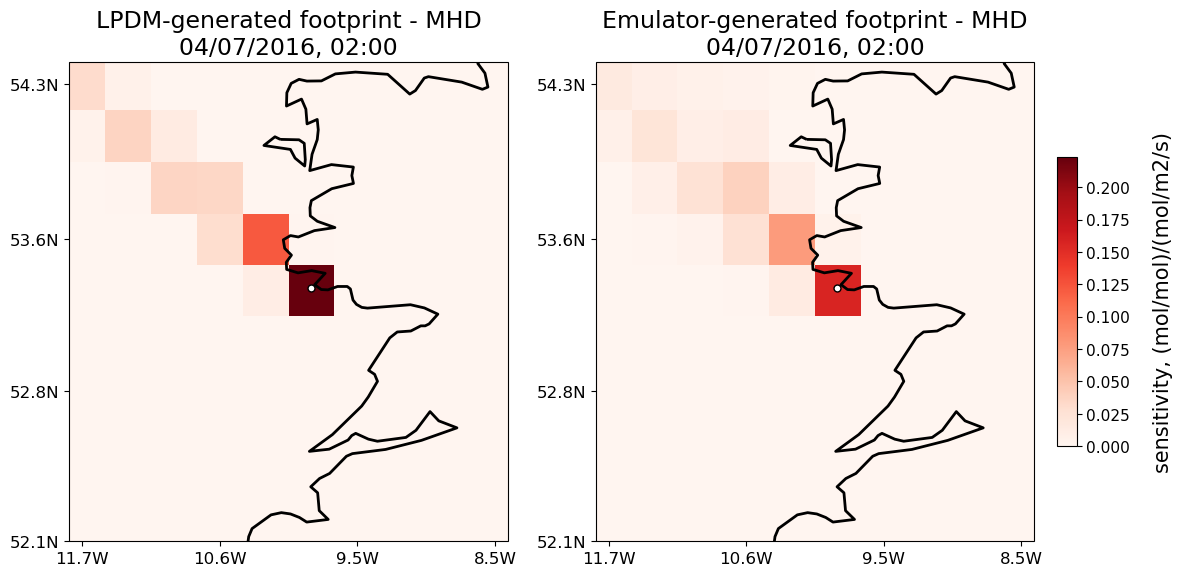

In [161]:
## plot the footprint for a particular date
t = "2:00 7/4/2016"
plot_footprint(predictions, data, t)

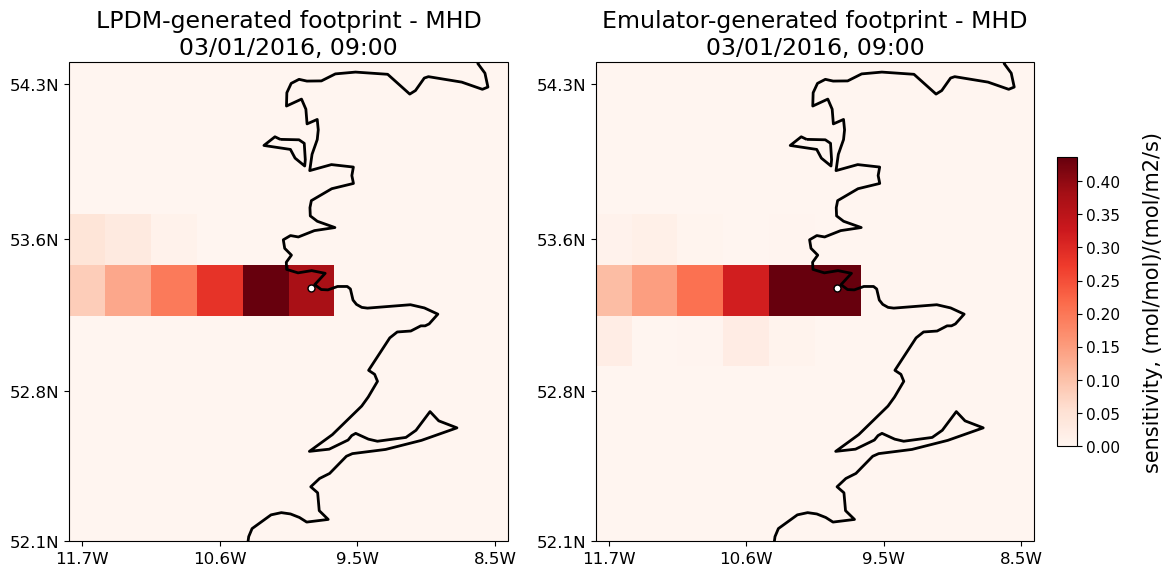

In [164]:
# t can also be an int, to plot the footprint with that index.
# this allows for an iteration: 
try:
    plot_footprint(predictions, data, t)
    t+=3
except:
    t=0
    print("initialising")

In [ ]:
## calculate metrics (TODO)